📥 Loading data from PostgreSQL (ahaems_cleaned)...


,quarter,AHAEMS2_Denominator,AHAEMS2_Numerator,AHAEMS2_Percentage
0,2024Q1,151,151,100.0
1,2024Q2,149,149,100.0
2,2024Q3,64,64,100.0
3,2024Q4,155,155,100.0
4,2025Q1,139,139,100.0
5,2025Q2,97,97,100.0


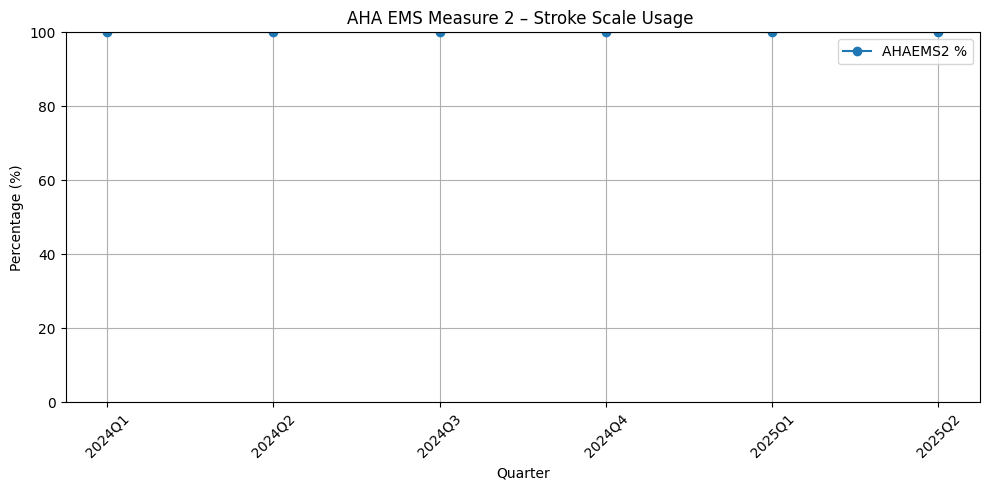

In [2]:
# === Standard Imports ===
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import display

# === Project Path Setup ===
import sys
from pathlib import Path
sys.path.append(str(Path.home() / "work" / "EMS_QI_Projects" / "ahaems-2025-submission"))

# === Project Resources ===
from project_paths import BASE_DIR, FALLOUTS_DIR, REPORTS_DIR, print_project_paths
from config import load_cleaned_data

# === Load Cleaned Data ===
print("📥 Loading data from PostgreSQL (ahaems_cleaned)...")
df = load_cleaned_data()

# === Rename for internal use ===
df = df.rename(columns={
    "UniqueIncidentKey": "incident_id",
    "Patient Age (ePatient.15)": "age",
    "Patient Age Units (ePatient.16)": "age_units",
    "Primary Impression": "primary_impression",
    "Secondary Impression": "secondary_impression",
    "Transport Disposition": "transport_disposition",
    "Response Type Of Service Requested With Code (eResponse.05)": "response_type",
    "Situation Last Known Well Date Time (eSituation.18)": "lkw_time",
    "Vitals Signs Taken Date Time (eVitals.01)": "vitals_time",
    "Cardiac Arrest During EMS Event With Code (eArrest.01)": "cardiac_arrest",
    "Disposition Final Patient Acuity Code (eDisposition.19)": "final_acuity"
})

# === Convert datetime fields ===
df["lkw_time"] = pd.to_datetime(df["lkw_time"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
df["vitals_time"] = pd.to_datetime(df["vitals_time"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

# === Extract ICDs from impressions ===
def extract_icd_prefix(text):
    if isinstance(text, str):
        match = re.search(r"\(([A-Z]\d{2}(?:\.\d+)?)\)", text.upper())
        if match:
            return match.group(1)[:3]
    return ""

df["primary_icd"] = df["primary_impression"].apply(extract_icd_prefix)
df["secondary_icd"] = df["secondary_impression"].apply(extract_icd_prefix)

# === Aggregate to 1 row per incident ===
grouped = df.groupby("incident_id").agg({
    "age": "first",
    "age_units": "first",
    "primary_icd": "first",
    "secondary_icd": "first",
    "transport_disposition": "first",
    "response_type": "first",
    "vitals_time": "min",
    "lkw_time": "first",
    "cardiac_arrest": "first",
    "final_acuity": "first"
}).reset_index()

# === Add Quarter ===
grouped["quarter"] = grouped["vitals_time"].dt.to_period("Q")

# === Denominator Logic ===
grouped["age"] = pd.to_numeric(grouped["age"], errors="coerce")
age_valid = (grouped["age"] >= 18) & (grouped["age_units"].str.lower() == "years")
stroke_icds = ["I60", "I61", "I63", "G45", "G46"]
impression_valid = grouped["primary_icd"].isin(stroke_icds) | grouped["secondary_icd"].isin(stroke_icds)
transport_valid = grouped["transport_disposition"].str.contains("transport by", case=False, na=False)
response_valid = grouped["response_type"].str.contains("2205001|2205003|2205009", na=False)

# Exclusion 1: LKW ≥ 24hr before vitals
exclude_lkw = (
    grouped["lkw_time"].notna() & grouped["vitals_time"].notna() &
    ((grouped["vitals_time"] - grouped["lkw_time"]).dt.total_seconds() >= 86400)
)

# Exclusion 2: Cardiac Arrest
exclude_arrest = grouped["cardiac_arrest"].astype(str).isin(["3001003", "3001005"])

# Exclusion 3: Final Acuity - Dead
exclude_acuity = grouped["final_acuity"].astype(str) == "4219909"

grouped["in_denominator"] = (
    age_valid & impression_valid & transport_valid & response_valid &
    ~exclude_lkw & ~exclude_arrest & ~exclude_acuity
)

# === Numerator Logic ===
# LKW is valid if NOT in null or not/unknown codes
invalid_lkw_values = ["7701001", "7701003", None, "", pd.NaT]
grouped["in_numerator"] = grouped["in_denominator"] & ~grouped["lkw_time"].astype(str).isin(invalid_lkw_values)

# === Summary ===
summary = (
    grouped[grouped["in_denominator"]]
    .groupby("quarter")
    .agg(
        AHAEMS2_Denominator=("in_denominator", "sum"),
        AHAEMS2_Numerator=("in_numerator", "sum")
    )
    .reset_index()
)
summary["AHAEMS2_Percentage"] = (summary["AHAEMS2_Numerator"] / summary["AHAEMS2_Denominator"] * 100).round(2)
display(summary)

# === Plot AHA Measure 1 Line Graph ===
plt.figure(figsize=(10, 5))
plt.plot(summary["quarter"].astype(str), summary["AHAEMS2_Percentage"], marker="o", linestyle="-", label="AHAEMS2 %")
plt.title("AHA EMS Measure 2 – Stroke Scale Usage ")
plt.xlabel("Quarter")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# === Export Fallout CSV ===
fallouts = grouped[grouped["in_denominator"] & ~grouped["in_numerator"]]
fallout_path = FALLOUTS_DIR / "ahaems2_fallouts.csv"

# Ensure directory exists before writing
os.makedirs(fallout_path.parent, exist_ok=True)

# Write fallout file
fallouts.to_csv(fallout_path, index=False)

from project_paths import OUTPUT_DIR

# Save the summary chart to output/charts/
chart_path = OUTPUT_DIR / "charts" / "ahaems2_chart.png"
os.makedirs(chart_path.parent, exist_ok=True)
plt.savefig(chart_path, bbox_inches="tight")